In [2]:
import numpy as np
from c_lang_integers import CUInt, UInt8, UInt16, UInt32

# Modeling

We want to steer a linear motion of a camera by mobile phone or computer.
The overall system consists of an Arduino UNO, a stepper motor with driver and a linear guide with thread drive.

![Model Overview](modeling.svg)

(Those components are chosen because I had them lying around, not because they are the best fit.)

We roll up the system from its end, the camera mount.
The screw drive is moving the camera mount and the rotation of the screw drive is driven by the stepper motor.
We assume 3 mm of linear  movement per revolution.
The stepper motor needs 200 steps per revolution, and the stepper motor in use breaks this down into even more micro steps, so we end up with 1600 steps per revolution.
We summarize those relationships in the formula 

$x = m \cdot n$.

The variable $x$ is the position, $m$ denotes the overall transmission ratio and $n$ is the number of steps done.
The number of steps is prescribed by our microcontroller (Arduino, ATMEGA 328P).
Besides the number, we can control the frequency $f_\mathrm{stepper}$ of the steps, which prescribes the velocity $v$ of the linear movement.
Dividing the previous formula by the time interval $\Delta t$ the stepper needed to do $n$ steps, moving the camera mount by distance $x$, we get

$v = m \cdot f_\mathrm{stepper}$.

The microcontroller has to generate pulses with a constant frequency.

![Constant Frequency Pulses](constant_pulses.svg)

The signal can be generated with the timer peripheral and in principal we are done.
We use CDT mode with one timer to generate the rate and another timer to determine the pulse length.
With regards to the rate we introduce the number of timer cycles $k$, which is used as OCR value for the rate 
generation and can be calculated with

$k = f_\mathrm{timer} / f_\mathrm{stepper}$

Here the clock frequency $f_\mathrm{timer}$ of the timer peripheral is used.

However, with this solution, we are limited to a fixed velocity and this fixed velocity has to be rather slow.
Otherwise, the motor might loose steps at start or does not run at all.

To overcome these limitations, we introduce a trapezodial velocity profile, defined by the acceleration $a$.

![A trapezodial velocity profile](trapezodial_velocity_profile.svg)

Subsequently, we can not use a fixed timer configuration anymore, but have to adapt the configuration between each step during acceleration and deacceleration.
Acceleration and deacceleration are more or less equal, we assess the acceleration only.
Here we calculate the velocity with

$v = a_\mathrm{a} \cdot \left( t - t_0 \right)$.

With the constant $a_\mathrm{a}$, we get the linear behavior over time $t$.
We have to calculate $k$ and adapt it regularly, to mimic this behavior with our timer peripheral.
$k$ can be calculated, using

$k(t) = \frac{f_\mathrm{timer}}{f_\mathrm{stepper}} = \frac{f_\mathrm{timer} \cdot m}{a \cdot (t - t_0)}$.

Each step, takes a certain period of time.
Therefore $k(t)$ has to be evaluated only at certain points in time.
Eventually, we get a sequence $k_i$ instead of a function.
With the sequence, $t$ becomes $t_i$ which can be determined with

$t_i = \frac{\sum_{j=0}^{i-1} k_i}{f_\mathrm{timer}}$

This is a division of pretty big numbers, and keeps the microcontroller busy for some time.
To circumvent compute time bottlenecks, we transform this problem into another counter.
The value $k$ is correlated to the time a step takes ($\Delta t = k / f_\mathrm{timer}$) and to the velocity (see above).
So, we can determine the number of stepper steps, the system can make for each value of $k$ before it has to adapt $k$ to maintain the acceleration.
We call this value $k_\mathrm{sumlim}(k)$ and it is determined by

$k_\mathrm{sumlim}(k) = \frac{f_\mathrm{timer} \cdot m}{a} \left( \frac{1}{k_i} - \frac{1}{k_i-1}\right) $

Now, all we have to to, is starting with some value of $k$, for example $k = 255$, repeat steps with this value until we reached $k_\mathrm{sumlim}(k=255)$ and then decrement $k$ by one and do the same with the next value.
Given $k$ is bigger than $k_\mathrm{sumlim}(k)$ we skip $k$s until we consumed the sum of $k_\mathrm{sumlim}$s is equal $k$.

## Parameters

In [3]:
# Transmission ratio m
m = 3 / 1600

# acceleration and deacceleration set point
a = 30

# velocity set point
v_set = 10

# position set point
x_set = 15

# clock frequency (atmega)
f_clk = 16e6

# counter with (8bit)
n_cnt = 255

# timer prescaler
prescaler = 256

# timer frequency
f_timer = f_clk / prescaler

## Prescale options

In [4]:
prescale_values = [1, 8, 32, 64, 128, 256, 1024]

f_timer_arr = f_clk / np.array(prescale_values)

min_velocities = f_timer_arr / 255 * m
max_velocities = f_timer_arr / 2 * m

np.vstack((prescale_values, min_velocities, max_velocities)).T

array([[1.00000000e+00, 1.17647059e+02, 1.50000000e+04],
       [8.00000000e+00, 1.47058824e+01, 1.87500000e+03],
       [3.20000000e+01, 3.67647059e+00, 4.68750000e+02],
       [6.40000000e+01, 1.83823529e+00, 2.34375000e+02],
       [1.28000000e+02, 9.19117647e-01, 1.17187500e+02],
       [2.56000000e+02, 4.59558824e-01, 5.85937500e+01],
       [1.02400000e+03, 1.14889706e-01, 1.46484375e+01]])

## Precalculated Steps

In [5]:
Dks = {n: round(m * f_timer**2 / a  * (1/(n-1) - 1/n)) for n in range(255, 2, -1)}

## Movement Planning

### Acceleration phase

In [6]:
k = UInt8(255)
Dk = UInt16(Dks[k.value])
p = UInt8(0)
pk = UInt16(0)

movement_plan = [
    [k.value, 1]
]

# 
f_clk100 = UInt16(int(f_clk / 100))

k_target = round(m * f_timer / v_set)

assert k_target in Dks.keys()

while k.value > k_target and p.value < x_set:

    if Dk.value > k.value:
        Dk -= k
    else:
        r = UInt16(k.value) - Dk
        k -= 1
        
        while r.value > Dks[k.value]:
            r -= Dks[k.value]
            k -= 1

        Dk = UInt16(Dks[k.value]) - r

    if k.value == movement_plan[-1][0] and movement_plan[-1][1] < 255:
        movement_plan[-1][1] += 1
    else:
        movement_plan.append([k.value, 1])

    pk += 1

    if (pk.value > 533):
        pk = UInt16(0)
        p += 1

p_acc = CUInt(p)
pk_acc = CUInt(pk)

In [7]:
len(movement_plan)

81

### Steady Phase

In [8]:
p.value, k

(1, CInt(12,1))

In [9]:
while (p.value + 1) < (x_set - p_acc.value) \
    or ((p.value + 1 == x_set - p_acc.value) and pk.value < 533 - pk_acc.value):

    if k_target == movement_plan[-1][0] and movement_plan[-1][1] < 255:
        movement_plan[-1][1] += 1
    else:
        movement_plan.append([k_target, 1])

    pk += 1

    if (pk.value > 533):
        pk = UInt16(0)
        p += 1


In [10]:
len(movement_plan)

105

In [11]:
p, pk, p_acc, pk_acc

(CInt(13,1), CInt(246,2), CInt(1,1), CInt(287,2))

### Deacceleration

In [12]:

Dk = r

while p.value < x_set:

    if Dk.value > k.value:
        Dk -= k
    else:
        r = UInt16(k.value) - Dk
        k += 1
        
        while r.value > Dks[k.value] and k.value <= 254:
            r -= Dks[k.value]
            k += 1

        Dk = UInt16(Dks[k.value]) - r

    if k.value == movement_plan[-1][0] and movement_plan[-1][1] < 255:
        movement_plan[-1][1] += 1
    else:
        movement_plan.append([k.value, 1])

    pk += 1

    if (pk.value > 533):
        pk = UInt16(0)
        p += 1

## Display Movement

In [13]:
steps = sum([cnt*[n] for n, cnt in movement_plan], [])

In [14]:
len(steps)

8011

In [15]:
t_s = []
v_s = []
x_s = []

x = 0
t = 0

for n in steps:
    T = n / f_timer
    t += T
    x += m

    t_s.append(t)
    v_s.append(m/T)
    x_s.append(x)

In [16]:
from matplotlib import pyplot as plt

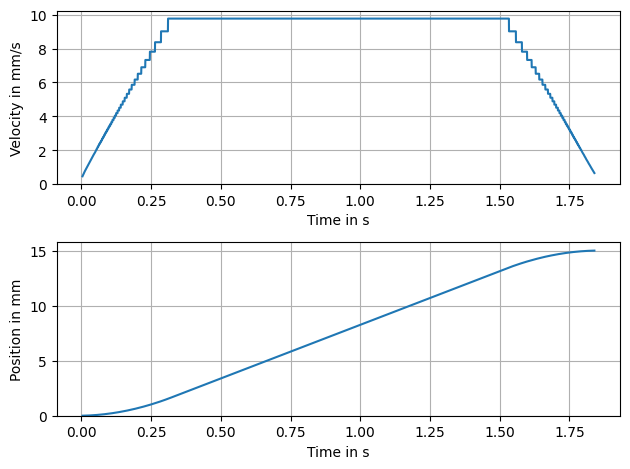

In [17]:
fig, [ax1, ax2] =  plt.subplots(2,1)

ax1.plot(t_s, v_s)

ax1.set_ylim((0,None))

ax1.set_xlabel("Time in s")
ax1.set_ylabel("Velocity in mm/s")
ax1.grid()

ax2.plot(t_s, x_s)

ax2.set_ylim((0,None))

ax2.set_xlabel("Time in s")
ax2.set_ylabel("Position in mm")
ax2.grid()

plt.tight_layout()

## Generate C Code

### Movment Plan

For testing purposes

In [36]:
template = """
static constexpr TrajectoryBlock movement_plan[] = {{
\t{}
}};
"""

generated_code = template.format(
    ",\n\t".join([*(f"{{{k}, {n}}}" for k, n in movement_plan)])
)

print(generated_code)


static constexpr TrajectoryBlock movment_plan[] = {
	{255, 1},
	{202, 1},
	{173, 1},
	{154, 1},
	{141, 1},
	{130, 1},
	{122, 1},
	{115, 1},
	{109, 1},
	{104, 1},
	{100, 1},
	{96, 1},
	{92, 1},
	{89, 1},
	{87, 1},
	{84, 1},
	{82, 1},
	{79, 1},
	{78, 1},
	{76, 1},
	{74, 1},
	{72, 1},
	{71, 1},
	{69, 1},
	{68, 1},
	{67, 1},
	{66, 1},
	{65, 1},
	{64, 1},
	{63, 1},
	{62, 1},
	{61, 1},
	{60, 1},
	{59, 1},
	{58, 1},
	{57, 2},
	{56, 1},
	{55, 1},
	{54, 2},
	{53, 2},
	{52, 1},
	{51, 2},
	{50, 2},
	{49, 2},
	{48, 3},
	{47, 2},
	{46, 3},
	{45, 2},
	{44, 3},
	{43, 3},
	{42, 4},
	{41, 3},
	{40, 4},
	{39, 4},
	{38, 5},
	{37, 5},
	{36, 5},
	{35, 6},
	{34, 7},
	{33, 7},
	{32, 7},
	{31, 9},
	{30, 9},
	{29, 10},
	{28, 12},
	{27, 13},
	{26, 14},
	{25, 17},
	{24, 18},
	{23, 21},
	{22, 24},
	{21, 27},
	{20, 33},
	{19, 37},
	{18, 44},
	{17, 53},
	{16, 64},
	{15, 77},
	{14, 96},
	{13, 120},
	{12, 255},
	{12, 255},
	{12, 255},
	{12, 255},
	{12, 255},
	{12, 255},
	{12, 255},
	{12, 255},
	{12, 255},
	{12, 255}

'{255, 1},\n{202, 1},\n{173, 1},\n{154, 1},\n{141, 1},\n{130, 1},\n{122, 1},\n{115, 1},\n{109, 1},\n{104, 1},\n{100, 1},\n{96, 1},\n{92, 1},\n{89, 1},\n{87, 1},\n{84, 1},\n{82, 1},\n{79, 1},\n{78, 1},\n{76, 1},\n{74, 1},\n{72, 1},\n{71, 1},\n{69, 1},\n{68, 1},\n{67, 1},\n{66, 1},\n{65, 1},\n{64, 1},\n{63, 1},\n{62, 1},\n{61, 1},\n{60, 1},\n{59, 1},\n{58, 1},\n{57, 2},\n{56, 1},\n{55, 1},\n{54, 2},\n{53, 2},\n{52, 1},\n{51, 2},\n{50, 2},\n{49, 2},\n{48, 3},\n{47, 2},\n{46, 3},\n{45, 2},\n{44, 3},\n{43, 3},\n{42, 4},\n{41, 3},\n{40, 4},\n{39, 4},\n{38, 5},\n{37, 5},\n{36, 5},\n{35, 6},\n{34, 7},\n{33, 7},\n{32, 7},\n{31, 9},\n{30, 9},\n{29, 10},\n{28, 12},\n{27, 13},\n{26, 14},\n{25, 17},\n{24, 18},\n{23, 21},\n{22, 24},\n{21, 27},\n{20, 33},\n{19, 37},\n{18, 44},\n{17, 53},\n{16, 64},\n{15, 77},\n{14, 96},\n{13, 120},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{12, 255},\n{1